# ddpg

In [1]:
# == recnn ==
import sys
sys.path.append("../../../")
import recnn

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [5]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl",
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)

CPU times: user 433 ms, sys: 103 ms, total: 536 ms
Wall time: 536 ms


In [9]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss

value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)

from time import gmtime, strftime
ddpg.writer = SummaryWriter(log_dir='../../../runs/DDPG{}'.format(strftime("%H_%M", gmtime())))
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

step 1350


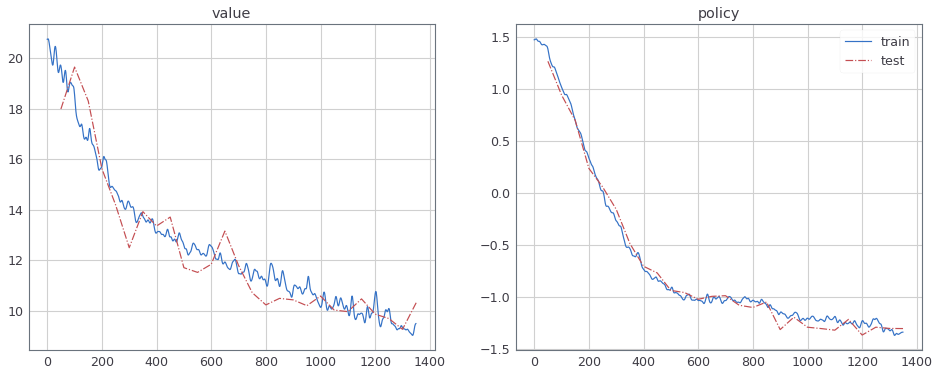

26%|██▌       | 1364/5263 [01:22<03:56, 16.50it/s]


KeyboardInterrupt: 

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 5000:
                return
            
learn()

In [10]:
torch.save(ddpg.nets['policy_net'].state_dict(), '../../../models/ddpg_policy.model')
torch.save(ddpg.nets['value_net'].state_dict(), '../../../models/ddpg_value.model')